In [1]:
# %matplotlib inline
from numpy.random import RandomState
import numpy
import re
import matplotlib
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import accuracy_score, multilabel_confusion_matrix
from sklearn.multiclass import OneVsRestClassifier
from nltk.corpus import stopwords
from sklearn.svm import LinearSVC
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import Pipeline
import seaborn as sns
import string
from sklearn.decomposition import TruncatedSVD

In [2]:
import os
path_to_model = 'C:/Users/prana/Desktop/BE Project/LegalBuddyServer/OPPClassifiers/SecondaryClassifiers/Models/PolicyChange/NotificationType.sav'
# os.listdir(path_to_model)

# Create Multilabel Dataset

In [3]:
#preprocess
df = pd.read_csv('dataset.csv')
df = df.dropna()

classes = list(df.Category.unique())
total_unique_clauses = df.Clause.unique().size

#creating dict for appending
classes_dict = {}
for single_class in classes:
    classes_dict[single_class] = list(numpy.zeros(total_unique_clauses))

#creating the df
data = {}
for index,row in df.iterrows():
    try : 
        data[row['Clause']].append(row['Category'])
        data[row['Clause']] = list(set(data[row['Clause']]))  
    except:
        data[row['Clause']] = [row['Category']]

        Clause = []
Category = []
for key in data.keys():
    Clause.append(key)
    Category.append(data[key])
    
data = pd.DataFrame({
    'Clause' : Clause,
    'Category' : Category
})
index = 0
for category_list in data.Category:
    for category in category_list:
        classes_dict[category][index] = 1
    index += 1

classes_dict = pd.DataFrame(classes_dict)

In [4]:
data.head()

,Clause,Category
0,contact you as necessary,[Personal notice]
1,we reserve the right to contact you as necessa...,[Unspecified]
2,we reserve the right to contact you as necessary,[Personal notice]
3,notice on the Site,[General notice on website]
4,contacting you through electronic mail or othe...,[Personal notice]


In [5]:
classes_dict.head()

,Personal notice,Unspecified,General notice on website,Other,General notice in privacy policy,No notification
0,1.0,0.0,0.0,0.0,0.0,0.0
1,0.0,1.0,0.0,0.0,0.0,0.0
2,1.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,1.0,0.0,0.0,0.0
4,1.0,0.0,0.0,0.0,0.0,0.0


In [6]:
one_hot_encoded_data = pd.concat([data, classes_dict], axis=1)
one_hot_encoded_data.drop(columns=['Category']).to_csv('multilabel_dataset.csv')

In [7]:
df = pd.read_csv('multilabel_dataset.csv')
df = df.dropna()
train = df.sample(frac=0.8, random_state = RandomState())
test = df.loc[~df.index.isin(train.index)]
validation = train.sample(frac=0.2, random_state=200)

In [8]:
df.columns.values[2:]

array(['Personal notice', 'Unspecified', 'General notice on website',
       'Other', 'General notice in privacy policy', 'No notification'],
      dtype=object)

# Visualizing Data

In [9]:
counts = []
categories = list(df.columns.values[2:])
for i in categories:
    counts.append((i, df[i].sum()))
df_stats = pd.DataFrame(counts, columns=['category', 'number_of_comments'])
df_stats

,category,number_of_comments
0,Personal notice,80.0
1,Unspecified,76.0
2,General notice on website,95.0
3,Other,24.0
4,General notice in privacy policy,145.0
5,No notification,19.0


Text(0.5, 0, 'category')

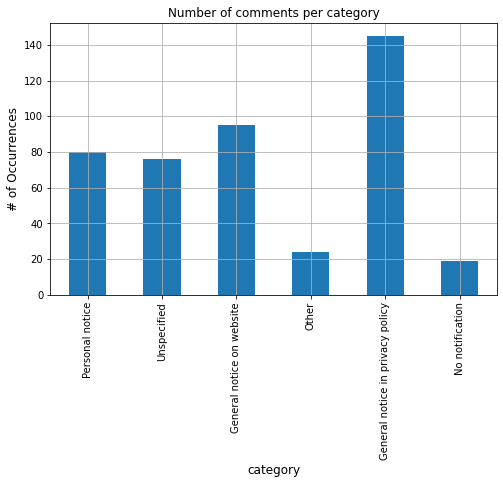

In [10]:
df_stats.plot(x='category', y='number_of_comments', kind='bar', legend=False, grid=True, figsize=(8, 5))
plt.title("Number of comments per category")
plt.ylabel('# of Occurrences', fontsize=12)
plt.xlabel('category', fontsize=12)

# Preprocessing Data

In [11]:
# cleaned_clause = []
# for clause in df.Clause:
#     clause = clause.lower()
#     clause = re.sub(r'[0-9]+', '',clause) #number removal
#     clause = clause.translate(string.maketrans(“”,””), string.punctuation) #removinf punctuations
#     clause = clause.strip() #whitespace removal
#     clause
#     break

In [12]:
x_test = test.Clause
x_train = train.Clause

In [13]:
y = train.iloc[:,2:]
y_test = test.iloc[:,2:]

categories = list(y.columns)

In [14]:
tfidf = TfidfVectorizer()
tfidf.fit_transform(df.Clause)

<419x697 sparse matrix of type '<class 'numpy.float64'>'
	with 5396 stored elements in Compressed Sparse Row format>

# Naive Bayes

In [15]:
prediction_pd = {}
classifier_list_nb = []
for category in categories:
    clf = OneVsRestClassifier(MultinomialNB(fit_prior=True, class_prior=None))
    print('... Processing {}'.format(category))
    clf.fit(tfidf.transform(x_train), y[category])
    prediction = clf.predict(tfidf.transform(x_test))
    print('Test accuracy is {}'.format(accuracy_score(y_test[category], prediction)))
    prediction_pd[category] = prediction
    classifier_list_nb.append(clf)
prediction_pd = pd.DataFrame(prediction_pd)
multilabel_confusion_matrix(y_test, prediction_pd)

... Processing Personal notice
Test accuracy is 0.9404761904761905
... Processing Unspecified
Test accuracy is 0.7857142857142857
... Processing General notice on website
Test accuracy is 0.7261904761904762
... Processing Other
Test accuracy is 0.9404761904761905
... Processing General notice in privacy policy
Test accuracy is 0.7976190476190477
... Processing No notification
Test accuracy is 0.9880952380952381


array([[[76,  1],
        [ 4,  3]],

       [[66,  0],
        [18,  0]],

       [[58,  0],
        [23,  3]],

       [[79,  0],
        [ 5,  0]],

       [[49,  3],
        [14, 18]],

       [[83,  0],
        [ 1,  0]]], dtype=int64)

# Linear SVC

In [16]:
prediction_pd = {}
classifier_list_svc = []
clf = OneVsRestClassifier(LinearSVC(), n_jobs=1)
for category in categories:
    print('... Processing {}'.format(category))
    clf.fit(tfidf.transform(x_train), y[category])
    prediction = clf.predict(tfidf.transform(x_test))
    print('Test accuracy is {}'.format(accuracy_score(y_test[category], prediction)))
    prediction_pd[category] = prediction
    classifier_list_svc.append(clf)
prediction_pd = pd.DataFrame(prediction_pd)
multilabel_confusion_matrix(y_test, prediction_pd)

... Processing Personal notice
Test accuracy is 0.9404761904761905
... Processing Unspecified
Test accuracy is 0.7738095238095238
... Processing General notice on website
Test accuracy is 0.8809523809523809
... Processing Other
Test accuracy is 0.9285714285714286
... Processing General notice in privacy policy
Test accuracy is 0.8452380952380952
... Processing No notification
Test accuracy is 1.0


array([[[75,  2],
        [ 3,  4]],

       [[61,  5],
        [14,  4]],

       [[58,  0],
        [10, 16]],

       [[78,  1],
        [ 5,  0]],

       [[46,  6],
        [ 7, 25]],

       [[83,  0],
        [ 0,  1]]], dtype=int64)

# Logistic Regression

In [17]:
prediction_pd = {}
classifier_list_lr = []
clf = OneVsRestClassifier(LogisticRegression(solver='sag'), n_jobs=1)
for category in categories:
    print('... Processing {}'.format(category))
    clf.fit(tfidf.transform(x_train), y[category])
    prediction = clf.predict(tfidf.transform(x_test))
    print('Test accuracy is {}'.format(accuracy_score(y_test[category], prediction)))
    prediction_pd[category] = prediction
    classifier_list_lr.append(clf)
prediction_pd = pd.DataFrame(prediction_pd)
multilabel_confusion_matrix(y_test, prediction_pd)

... Processing Personal notice
Test accuracy is 0.9523809523809523
... Processing Unspecified
Test accuracy is 0.7857142857142857
... Processing General notice on website
Test accuracy is 0.7976190476190477
... Processing Other
Test accuracy is 0.9404761904761905
... Processing General notice in privacy policy
Test accuracy is 0.8571428571428571
... Processing No notification
Test accuracy is 0.9880952380952381


array([[[76,  1],
        [ 3,  4]],

       [[66,  0],
        [18,  0]],

       [[58,  0],
        [17,  9]],

       [[79,  0],
        [ 5,  0]],

       [[50,  2],
        [10, 22]],

       [[83,  0],
        [ 1,  0]]], dtype=int64)

In [18]:
import pickle
#saving model
list_of_classifiers = classifier_list_nb
pickle.dump((tfidf, list_of_classifiers), open(path_to_model, 'wb'))

In [17]:
with open(path_to_model, 'rb') as model:
    vect, clfs = pickle.load(model)

In [16]:
clfs

[OneVsRestClassifier(estimator=LogisticRegression(C=1.0, class_weight=None,
                                                  dual=False, fit_intercept=True,
                                                  intercept_scaling=1,
                                                  l1_ratio=None, max_iter=100,
                                                  multi_class='auto',
                                                  n_jobs=None, penalty='l2',
                                                  random_state=None,
                                                  solver='sag', tol=0.0001,
                                                  verbose=0, warm_start=False),
                     n_jobs=1),
 OneVsRestClassifier(estimator=LogisticRegression(C=1.0, class_weight=None,
                                                  dual=False, fit_intercept=True,
                                                  intercept_scaling=1,
                                                  l1_ratio=